In [1]:
import pandas as pd
import numpy as np
from math import erf
import matplotlib.pyplot as plt
%matplotlib inline

NUM_ITER = 10000

In [2]:
df = pd.read_csv("1976-2020-president.csv")

In [3]:
ELECTIONYEAR = 2024
df = df[df['year']<ELECTIONYEAR]


In [4]:
df['party_simplified'] = df['party_simplified'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else '3RDPARTY')

# Step 2: Aggregate the votes for "3RDPARTY"
df_grouped = df.groupby(['year', 'state_po', 'party_simplified'], as_index=False).agg({'candidatevotes': 'sum'})

# Step 3: Pivot the table
matrix = df_grouped.pivot_table(index='state_po', columns=['party_simplified','year'], values='candidatevotes', fill_value=0)


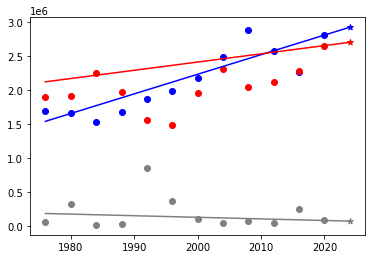

In [5]:
prior_preds = {}
for i,row in matrix.iterrows():
    t = row["DEMOCRAT"].index.values
    that = np.append(t,ELECTIONYEAR)

    X3 = row["3RDPARTY"].values
    m3 = np.std(X3)/np.std(t)*np.corrcoef(X3,t)[0,1]
    b3 = X3[-1] - m3*t[-1]
    X3hats = m3*that + b3
    X3hat2024 = m3*ELECTIONYEAR + b3
    X3var = np.sum((X3-X3hats[:-1])**2) / (len(X3) - 2) / 100 #Adjustment to fix weird near 0 issue


    XD = row["DEMOCRAT"].values
    mD = np.std(XD)/np.std(t)*np.corrcoef(XD,t)[0,1]
    bD = XD[-1] - mD*t[-1]
    XDhats = mD*that + bD
    XDhat2024 = mD*ELECTIONYEAR + bD
    XDvar = np.sum((XD-XDhats[:-1])**2) / (len(XD) - 2)

    XR = row["REPUBLICAN"].values
    mR = np.std(XR)/np.std(t)*np.corrcoef(XR,t)[0,1]
    bR = XR[-1] - mR*t[-1]
    XRhats = mR*that + bR
    XRhat2024 = mR*ELECTIONYEAR + bR
    XRvar = np.sum((XR-XRhats[:-1])**2) / (len(XR) - 2)
    if i=="MI":
        fig,ax = plt.subplots()
        ax.scatter(t,X3,color='grey')
        ax.plot(that,X3hats,color='grey')
        ax.scatter(ELECTIONYEAR,X3hat2024,color='grey',marker='*')

        ax.scatter(t,XD,color='blue')
        ax.plot(that,XDhats,color='blue')
        ax.scatter(ELECTIONYEAR,XDhat2024,color='blue',marker='*')

        ax.scatter(t,XR,color='red')
        ax.plot(that,XRhats,color='red')
        ax.scatter(ELECTIONYEAR,XRhat2024,color='red',marker='*')

    prior_preds[row.name] = {
        "other_vote":X3hat2024,
        "other_var":X3var,
        "dem_vote" :XDhat2024,
        "dem_var": XDvar,
        "rep_vote": XRhat2024,
        "rep_var":XRvar,    }


In [6]:
prior_preds = pd.DataFrame(data=prior_preds).T

In [7]:
prior_vars_scaled = prior_preds[["other_var","dem_var","rep_var"]].copy()

prior_vars_scaled["other_var"] = (prior_vars_scaled["other_var"] / prior_preds["other_vote"]**2)*1 # Extrapolation penalty
prior_vars_scaled["dem_var"] = (prior_vars_scaled["dem_var"] / prior_preds["dem_vote"]**2)*1
prior_vars_scaled["rep_var"] = (prior_vars_scaled["rep_var"] / prior_preds["rep_vote"]**2)*1


prior_preds_scaled = prior_preds[["other_vote","dem_vote","rep_vote"]].copy()
prior_preds_votes = prior_preds_scaled.sum(axis=1)
prior_preds_scaled=prior_preds_scaled.div(prior_preds_votes,axis=0,)
prior_preds_scaled['total_vote_pred'] = prior_preds_votes
prior_preds_scaled_normalised = prior_preds_scaled.apply(lambda col: (col - np.average(col,weights=prior_preds_scaled["total_vote_pred"])))

poll_other = 0.046
poll_dem = 0.473
poll_rep = 0.436

# poll_other = 0.057
# poll_dem = 0.482
# poll_rep = 0.461

# poll_other = 0.019
# poll_dem = 0.513
# poll_rep = 0.468

post_preds_scaled_normalised = prior_preds_scaled_normalised.copy()
post_preds_scaled_normalised['other_vote'] += poll_other
post_preds_scaled_normalised['dem_vote'] += poll_dem
post_preds_scaled_normalised['rep_vote'] += poll_rep
post_preds_scaled_normalised.drop("total_vote_pred",axis=1,inplace=True)
post_preds_scaled_normalised = post_preds_scaled_normalised.div(post_preds_scaled_normalised.sum(axis=1),axis=0)



post_vars_scaled = prior_vars_scaled + 0.08**2

In [8]:
poll_other+ poll_dem+ poll_rep

0.9550000000000001

In [9]:
electoralvotes = {
    "AL":9,
    "AK":3,
    "AZ":11,
    "AR":6,
    "CA":54,
    "CO":10,
    "CT":7,
    "DC":3,
    "DE":3,
    "FL":30,
    "GA":16,
    "HI":4,
    "ID":4,
    "IL":19,
    "IN":11,
    "IA":6,
    "KS":6,
    "KY":8,
    "LA":8,
    "ME":4,
    "MD":10,
    "MA":11,
    "MI":15,
    "MN":10,
    "MS":6,
    "MO":10,
    "MT":4,
    "NE":5,
    "NV":6,
    "NH":4,
    "NJ":14,
    "NM":5,
    "NY":28,
    "NC":16,
    "ND":3,
    "OH":17,
    "OK":7,
    "OR":8,
    "PA":19,
    "RI":4,
    "SC":9,
    "SD":3,
    "TN":11,
    "TX":40,
    "UT":6,
    "VT":3,
    "VA":13,
    "WA":12,
    "WV":4,
    "WI":10,
    "WY":3}	


In [10]:
covariance_matrix = matrix.T.corr()
def to_cov(row,column):
    return row * (column.loc[row.name]) * column

In [11]:
rep_cov = matrix['REPUBLICAN'].T.corr().apply(lambda row: to_cov(row,post_vars_scaled['rep_var']))
dem_cov = matrix['DEMOCRAT'].T.corr().apply(lambda row: to_cov(row,post_vars_scaled['dem_var']))
oth_cov = matrix['3RDPARTY'].T.corr().apply(lambda row: to_cov(row,post_vars_scaled['other_var']))

In [12]:
outputs = []
for _ in range(NUM_ITER):
    election = pd.DataFrame(data = [np.clip(np.random.multivariate_normal(post_preds_scaled_normalised["rep_vote"],rep_cov),0,1),
                                    np.clip(np.random.multivariate_normal(post_preds_scaled_normalised["dem_vote"],dem_cov),0,1),
                                    np.clip(np.random.multivariate_normal(post_preds_scaled_normalised["other_vote"],oth_cov),0,1)
                            ], columns=rep_cov.columns,index=["rep_share","dem_share","oth_share"]).T
    
    harris_popular_vote = np.average(election['dem_share'],weights=prior_preds_scaled["total_vote_pred"])
    trump_popular_vote = np.average(election['rep_share'],weights=prior_preds_scaled['total_vote_pred'])
    oth_popular_vote = np.average(election['oth_share'],weights=prior_preds_scaled['total_vote_pred'])
    
    election['margin']=election["dem_share"] - election["rep_share"]
    election.sort_values(by='margin',ascending=False,inplace=True)

    election['winner']=["Harris"if res else "Trump" for res in election['margin']>0 ]

    election["Cummulative Trump EV"] = 0
    election["Cummulative Harris EV"] = 0



    harris_ev = 0
    trump_ev = 0
    other_ev = 0


    for state_name, result in election.iterrows():
        if result['winner']=="Harris":
            harris_ev += electoralvotes[state_name]
            election.loc[state_name,"Cummulative Harris EV"] = harris_ev

    election.sort_values(by='margin',ascending=True,inplace=True)
    for state_name, result in election.iterrows():
        if result['winner']=="Trump":
            trump_ev += electoralvotes[state_name]
            election.loc[state_name,"Cummulative Trump EV"] = trump_ev

    # Check if Electoral Vote Tie
    if (election[["Cummulative Harris EV","Cummulative Trump EV"]]==269).any().all():
        tipping_point_state = election[(election[["Cummulative Harris EV","Cummulative Trump EV"]]==269).any(axis=1)]['margin'].abs().idxmin()
    else:
        tipping_point_state = election[(election[["Cummulative Harris EV","Cummulative Trump EV"]]>= 270).any(axis=1)][["Cummulative Harris EV","Cummulative Trump EV"]].sum(axis=1).idxmin()
 


    output_df = election[["rep_share","dem_share","oth_share","winner"]]
    output = {
        "df":output_df,
        "facts":{
            "harris_popular_vote":harris_popular_vote,
            "trump_popular_vote":trump_popular_vote,
            "oth_popular_vote":oth_popular_vote,
            "tipping_point_state":tipping_point_state,
            "harris_ev":harris_ev
        }
    }
    outputs.append(output)

In [13]:
combined_df = pd.concat([output['df'] for output in outputs],axis=0)
median_df = combined_df.groupby(level=0).median()

In [14]:
def ensure_harris(counts):
    if "Harris" not in counts:
        counts["Harris"] = 0
    return counts
state_probs = combined_df.groupby(combined_df.index)["winner"].apply(lambda x: x.value_counts())
state_probs = state_probs.groupby(level=0).apply(ensure_harris)
state_probs = state_probs.reset_index(level=1, drop=True).unstack(fill_value=0).drop('',axis=1)

In [15]:
model_outputs = {}
for i,row in median_df.iterrows():
    p_dem_win = state_probs.loc[i,"Harris"] / state_probs.loc[i].sum()
    dem_margin_median = row["dem_share"] - row["rep_share"]


    model_outputs[i] = {
        "Probability Harris Win":p_dem_win,
        "Median Harris Margin":dem_margin_median,
        "Harris Voteshare":row["dem_share"],
        "Trump Voteshare":row["rep_share"],
        "Other Voteshare":row["oth_share"],
        "Total Number of Votes":prior_preds_scaled.loc[i,"total_vote_pred"],
        "EV":electoralvotes[i]
    }
model_outputs = pd.DataFrame(data = model_outputs).T

In [16]:
text = model_outputs.apply(lambda row:
                           f" <b><i>{df[['state','state_po']].set_index('state_po').to_dict()['state'][row.name]}</i> {int(row['EV'])} EV's</b> \
                           <br><i>Probability Harris Wins</i>: <b>{np.round(row['Probability Harris Win']*100,1)}%</b> \
                           <br><i>Predicted Harris Voteshare</i>: <b>{np.round(row['Harris Voteshare']*100,1)}%</b> \
                            <br><i>Predicted Trump Voteshare</i>: <b>{np.round(row['Trump Voteshare']*100,1)}%</b> \
                           <br><i>Predicted Other Voteshare</i>: <b>{np.round(row['Other Voteshare']*100,1)}%</b> \
                            ",axis=1)

In [17]:
republican_red = "#cf1313"
democratic_blue = "#116dc2"
chloropleth_cmap = [(0, republican_red),(0.5,"white"), (1, democratic_blue)]
histogram_cmap = [(0, "red"),(0.4, "red"), (0.5,"#c478b1"), (0.6, "blue"), (1, "blue")]

In [18]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=model_outputs.index, # Spatial coordinates
    z = model_outputs["Probability Harris Win"], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = chloropleth_cmap,
    # colorbar_title = "Probability Harris Win",
    text = text,
    hoverinfo="text",
    showscale=False
))

fig.update_layout(
    # title_text = f'2024 Electoral Forecast: Kamala Harris has a {OVERALL["Probability Harris Win"].round(3)*100}% chance to win the election',
    geo_scope='usa', # limite map scope to USA
    title=None,  # Remove title
    margin={"r":0,"t":0,"l":0,"b":0},  # Adjust margins to remove extra space
)

fig.write_html("docs/chloropleth.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [19]:
run = [output['facts']['harris_ev'] for output in outputs]

In [20]:
counts,bins = np.histogram(run,bins=85,range=(100,440))

In [21]:
text = [f"<b>Harris wins between {int(bins[i])} and {int(bins[i+1])} EV's in {count} runs \
        <br> out of {sum(counts)} simulations </b>" for i,count in enumerate(counts)]

In [22]:
fig = go.Figure(data=[go.Bar(
    x=bins,
    y=counts/sum(counts)*100,
    marker={'color': bins, 'colorscale': histogram_cmap},
    text =text,    
    hoverinfo='text',
    textposition = "none"
    )])
# Add titles and labels
fig.update_layout(
    # title='Histogram of Electoral Votes',
    xaxis_title='Harris Electoral College Vote',
    yaxis_title='Probability %',
)
fig.add_shape(
    go.layout.Shape(
        type='line',
        x0=270,
        y0=0,
        x1=270,
        y1=max(fig.data[0].y)*1.2,  # Adjust y1 to match the range of your data
        line=dict(
            color='Black',
            width=2,
            dash='dot',  # Dotted line
        ),
    )
)
fig.add_annotation(
    x=270,
    y=max(fig.data[0].y),  # Position text slightly below the top of the y-axis
    text="<b>Harris wins the election<b><br>---------->",
    showarrow=True,
    arrowhead=0,
    ax=85,  # X offset for the text
    ay=0,   # Y offset for the text
    font=dict(size=12, color="Black"),
    align='left'
)
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

# fig.show()
fig.write_html("docs/histogram.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [23]:
pwin = sum([output['facts']['harris_ev']>=270 for output in outputs])/NUM_ITER
median_ev = np.median([output['facts']['harris_ev'] for output in outputs])

In [24]:
(pd.Series([output['facts']['harris_popular_vote']-output['facts']['trump_popular_vote'] for output in outputs])>0).value_counts()

True     8650
False    1350
dtype: int64

In [25]:
pwin

0.5085

In [26]:
median_ev

274.0

In [27]:
tipping_points = pd.Series([output['facts']['tipping_point_state'] for output in outputs])
tipping_points.value_counts()/tipping_points.value_counts().sum()

PA    0.3323
WI    0.3085
AZ    0.1101
GA    0.0920
MI    0.0606
NC    0.0357
NV    0.0311
TX    0.0284
NY    0.0006
UT    0.0004
FL    0.0002
RI    0.0001
dtype: float64

In [28]:
for i in range(10):# Create the choropleth map
    fig = go.Figure(data=go.Choropleth(
        locations=outputs[i]['df'].index,  # State codes
        z=outputs[i]['df']['winner'].map({'Harris': 1, 'Trump': 0}),  # Numeric mapping of candidates
        locationmode='USA-states',  # Specify that locations are state codes
        colorscale=[[0, republican_red], [1, democratic_blue]],  # Define color scale (0 = Trump, 1 = Harris)
        showscale=False,  # Disable the color scale bar
        text=outputs[i]['df']['winner'],  # Hover text showing the candidate
    ))

    # Update layout for a better appearance
    fig.update_layout(
        # title_text="2024 Election Map",
        geo=dict(
            scope='usa',
            projection=go.layout.geo.Projection(type='albers usa'),
            showlakes=True,  # Show lakes
            lakecolor='rgb(255, 255, 255)',
            bgcolor='rgba(0,0,0,0)',  # Set background to transparent
        ),
        margin=dict(l=0, r=0, t=0, b=0)  # Constrain layout with tighter margins
    )

    fig.write_html(f"docs/assets/example_chloros/chloropleth_example_{i}.html",config={'staticPlot': True})